# The imports

In [1]:
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs

import matplotlib.pyplot as plt

import mapclassify as mc

# Loading the data

In [2]:
# Load Nepal district geometry data
map_data = gpd.read_file('/home/pratik/Projects/EQ map/data/nepal_map_data/nepal-districts.geojson')

# Load Nepal state geometry data for highlighting state boundaries
map_highlight_data = gpd.read_file('/home/pratik/Projects/EQ map/data/nepal_map_data/nepal-states.geojson')

# Lakes data, we only need the 2nd and 3rd columns
lakes_data = gpd.read_file('/home/pratik/Projects/EQ map/data/OpenDataNepal/NepalCBS/number-of-lakes-in-districts-by-altitude-in-nepal.csv').iloc[:, 1:3]

# Preprocess lakes data

In [3]:
# uppercase the district names, cast the count to int
lakes_data['District'] = lakes_data['District'].str.upper()
lakes_data['Total Lake'] = lakes_data['Total Lake'].astype(int)

# join lakes data and geodata on District
final_lakes_data = map_data.merge(lakes_data, how='inner', left_on=["DISTRICT"], right_on=["District"]).iloc[:,1:]

# Plot the number of lakes data as a choropleth

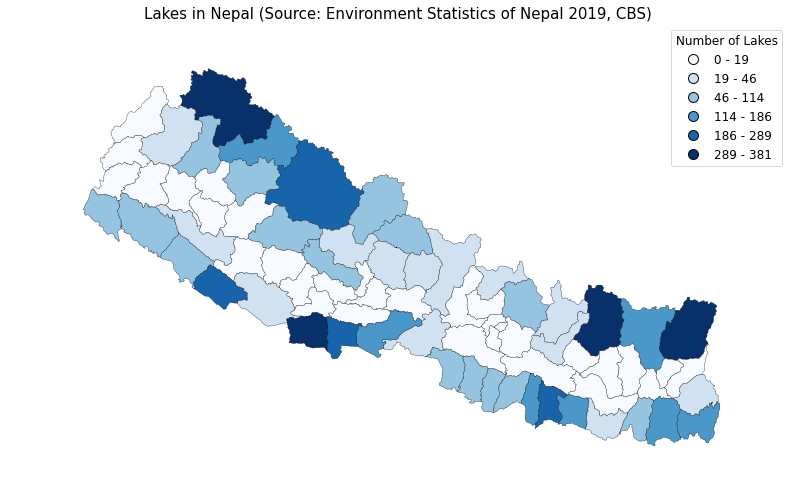

In [11]:
scheme = mc.FisherJenks(final_lakes_data['Total Lake'], k=6)

gplt.choropleth(
    final_lakes_data, figsize=(14,9),
    hue='Total Lake', projection=gcrs.AlbersEqualArea(),
    cmap='Blues', linewidth=0.3, edgecolor='black',
    legend_kwargs={"loc":"best",
                    "fontsize": "large",
                    "title":"Number of Lakes",
                    "title_fontsize":"large"},
    legend=True, scheme=scheme
)

plt.title("Lakes in Nepal (Source: Environment Statistics of Nepal 2019, CBS)", fontdict={"fontsize": 15}, pad=5)

# plt.savefig('../visualizations/LakesInNepal.svg', bbox_inches='tight')

In [84]:
final_lakes_data.to_crs('Albers_Equal_Area').area

CRSError: Invalid projection: Albers_Equal_Area: (Internal Proj Error: proj_create: several objects matching this name: Canada_Albers_Equal_Area_Conic, Hawaii_Albers_Equal_Area_Conic, Europe_Albers_Equal_Area_Conic, Africa_Albers_Equal_Area_Conic, Asia_North_Albers_Equal_Area_Conic, Asia_South_Albers_Equal_Area_Conic, ...)